In [1]:
import gtfs_functions as gtfs
import matplotlib
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import random
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# cluster visualizer
#%matplotlib inline
#from yellowbrick.cluster import KElbowVisualizer 

# sklearn kmeans
from sklearn.metrics.cluster import contingency_matrix

# pyclustering kmeans
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import distance_metric
from pyclustering.cluster.center_initializer import random_center_initializer
from pyclustering.cluster.encoder import type_encoding
from pyclustering.cluster.encoder import cluster_encoder
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture

path_gtfs ='C:/Users/Maison/Documents/INFO-H423/Projet Data Mining/GTFS3sep/gtfs3sept.zip'

routes, stops, stop_times, trips, shapes = gtfs.import_gtfs(path_gtfs,busiest_date=False)
stop_freq = gtfs.stops_freq(stop_times, stops)
line_freq = gtfs.lines_freq(stop_times, trips, shapes, routes)

Bon ici j'ai du code illisible et flemme de documenter, je document à la fin les deux fonctions importantes

In [2]:
calendardf = pd.read_table('calendar.txt',sep=',')          #export the calendar file into data frame
calendarDatesdf = pd.read_table('calendar_dates.txt',sep=',')  #also export the exceptions

In [4]:
def FromDayToService(date):
    '''Determine all the service_id concerned by a date, given in the format date=('20210907','tuesday')
        it first take a look at every regular service_id then examine the exceptions. 
        Returns a list of service_id of type string'''

    ListServiceId=[]
    for i in range(len(calendardf)):
        startdate,endate=calendardf.iloc[i,[8,9]]
        if int(date[0]) in range(int(startdate),int(endate)+1):
            if calendardf.loc[i,date[1]]==1:
                #It appends every service_id which contains the date, and for which there is a '1'
                # under right day in the week
                ListServiceId.append(str(calendardf.iloc[i,0]))     

    #Now we have to take a look a the exceptions
    #We selections all the exceptions in calendarDatesdf that concerns the date in the input
    ModifServiceId= calendarDatesdf[calendarDatesdf['date']==int(date[0])][['service_id','exception_type']]
    #print('Number of service_id involved in modifications: '+ str(len(ModifServiceId)))
    #for every modif we check the kind of exception
    for modif in ModifServiceId.iterrows():  
        service = str(modif[1]['service_id'])
        exception = modif[1]['exception_type']
        if exception == 1:
            #if the exception is 1, it means that we should change to a 1 the cell related to the date in
            # input, in the row equal to service in calendar
            ListServiceId.append(service)
            #print('ServiceId: '+str(service)+' correclty added' )
        elif (exception == 2) & (service in ListServiceId):
            #if the exception is 2, it means that we should change to a 0 the cell related to the date in
            # input, in the row equal to service in calendar
            #Since this service_id must have been selected in the first loop (in Calendar), we need to remove it
            ListServiceId.remove(service)
            #print('ServiceId: '+str(service)+' correclty removed' )
        elif (exception == 2) & (service not in ListServiceId):
            #if the exception is 2 but we haven't found the service id in the first loop, this is weird
            #In principle this should not happend, but we're never too carefull
            print('Warning : exception 2 but no service_id = ' +service+ ' found in calendar')
    return (ListServiceId)

def FromLineIdtoRouteId(LineId):
    
    '''Takes a lineid in argument a returns the correspondent routeid, since stop_times only 
        contains route_id'''

    routeId = routes[routes['route_short_name']==LineId]['route_id'].iloc[0]
    return routeId

def ScheduledTime(date,lineId,stopId):

    '''Takes a triplet (date,lineId,stopId) with date in the format date=('20210907','tuesday')
        and returns the schedule for that triplet. The schedule is composed as follows: if we are in a period of
        punctuality then returns the (arrivaltime,true), and if we are in regularity, 
        returns (TimeOfWaitFromPreviousVehicle,False), all in one list '''

    ListOfService = pd.Series(FromDayToService(date))  #List of service_id tha apply for that day
    RouteId = FromLineIdtoRouteId(lineId)               #We need the routeid to seek in the GTFS
    #We select the relevant rows in GTFS stop_times
    Scheduledf = stop_times[(stop_times['stop_id']==stopId)&(stop_times['route_id']==RouteId)&(stop_times['service_id'].isin(ListOfService))].sort_values('arrival_time')
    ArrivalTime = Scheduledf['arrival_time'].values
    #print('Number of service_id involved: '+ str(len(ListOfService)))
    #We compute every wainting time to determine punctuality of regularity (< or > 720 s)
    #Schedule = list(ArrivalTime[1:]-ArrivalTime[:-1])
    Schedule = list(ArrivalTime[1:]-ArrivalTime[:-1])
    Schedule.insert(0,ArrivalTime[0])
    #True if punctuality, False if regularity
    Punctuality = np.array(Schedule)>720 
    #Ultimately, if we are a punctuality, we want the arrival time and if we are in regularity, we want the 
    #time bewteen two vehicles
    for i,punctuality in enumerate(Punctuality):
        if punctuality:
            if (0<i<(len(Punctuality)-1)):
                if ~(Punctuality[i-1]) & ~(Punctuality[i+1]):
                    Punctuality[i]=False
            else:
                Schedule[i]=ArrivalTime[i]
 
    #Schedule = list(zip(Schedule,Punctuality))
    #The format is a list of tuples

    return Schedule,Punctuality,ArrivalTime

def RouteIdToLineId(routeId):
    lineId = routes[routes['route_id']==routeId]['route_short_name'].iloc[0]
    return lineId
        
def TroncatedScheduleRegularity(date,lineId,stopId):
    Schedulemom = ScheduledTime(date,lineId,stopId)
    TroncatedInterval = [intervaltime for i,intervaltime in enumerate(Schedulemom[0]) if not(Schedulemom[1][i])]
    TroncatedArrival = [arrivaltime for i,arrivaltime in enumerate(Schedulemom[2][:-1]) if not(Schedulemom[1][i])]
    return TroncatedInterval,TroncatedArrival


def RawScheduledTime(date,lineId,stopId):

    '''Takes a triplet (date,lineId,stopId) with date in the format date=('20210907','tuesday')
        and returns the schedule for that triplet. The schedule is composed as follows: if we are in a period of
        punctuality then returns the (arrivaltime,true), and if we are in regularity, 
        returns (TimeOfWaitFromPreviousVehicle,False), all in one list '''

    ListOfService = pd.Series(FromDayToService(date))  #List of service_id tha apply for that day
    RouteId = FromLineIdtoRouteId(lineId)               #We need the routeid to seek in the GTFS
    #We select the relevant rows in GTFS stop_times
    Scheduledf = stop_times[(stop_times['stop_id']==stopId)&(stop_times['route_id']==RouteId)&(stop_times['service_id'].isin(ListOfService))].sort_values('arrival_time')
    ArrivalTime = Scheduledf['arrival_time'].values
    #print('Number of service_id involved: '+ str(len(ListOfService)))
    #We compute every wainting time to determine punctuality of regularity (< or > 720 s)
    IntervalTime = list(ArrivalTime[1:]-ArrivalTime[:-1])
    #IntervalTime.insert(0,ArrivalTime[0])
    df = pd.DataFrame({'ArrivalTime':ArrivalTime[1:], 'TimeWaited':IntervalTime})
    return df

def DeltaTimeCompar(date,lineId,stopId):

    '''Takes a triplet (date,lineId,stopId) with date in the format date=('20210907','tuesday')
        and returns the schedule for that triplet. The schedule is composed as follows: if we are in a period of
        punctuality then returns the (arrivaltime,true), and if we are in regularity, 
        returns (TimeOfWaitFromPreviousVehicle,False), all in one list '''

    ListOfService = pd.Series(FromDayToService(date))  #List of service_id tha apply for that day
    RouteId = FromLineIdtoRouteId(lineId)               #We need the routeid to seek in the GTFS
    #We select the relevant rows in GTFS stop_times
    Scheduledf = stop_times[(stop_times['stop_id']==stopId)&(stop_times['route_id']==RouteId)&(stop_times['service_id'].isin(ListOfService))].sort_values('arrival_time')
    ArrivalTime = Scheduledf['arrival_time'].values
    #print('Number of service_id involved: '+ str(len(ListOfService)))
    #We compute every wainting time to determine punctuality of regularity (< or > 720 s)
    IntervalTime = list(ArrivalTime[1:]-ArrivalTime[:-1])
    IntervalTime_i = IntervalTime[:-1]
    IntervalTime_iplus1 = IntervalTime[1:]
    #IntervalTime.insert(0,ArrivalTime[0])
    df = pd.DataFrame({'IntervalTimei':IntervalTime_i, 'IntervalTimeiplus1':IntervalTime_iplus1})
    return df



In [5]:
StopTimesGroupTrip = stop_times.groupby('trip_id')[['stop_sequence']].mean().round()
StopTimesGroupTrip['stop_sequence']=StopTimesGroupTrip['stop_sequence'].astype(int)

test = pd.merge(stop_times, StopTimesGroupTrip, how='right', on= ['trip_id','stop_sequence'])

DicOfMiddleStop={}
test2 = test[['route_id','stop_sequence','stop_id','direction_id']]
for stop in test2['stop_id'].unique():
    test3 = test2[test2['stop_id']==stop]
    routeid = test3['route_id'].unique()[0]
    directionid = test3['direction_id'].unique()
    for direction in directionid:
        key = str(routeid)+':'+str(direction)
        if DicOfMiddleStop.get(key) is None:
            DicOfMiddleStop[key]=stop
DicOfWeek = {'weekday':('20210915','wednesday'),'saturday':('20210918','saturday'),'sunday':('20210919','sunday')}  
def DataForCluster(lineid, directionid,dayoftheweek):
    routeid = FromLineIdtoRouteId(lineid) 
    key = str(routeid)+':'+str(directionid)
    if DicOfMiddleStop.get(key)!=None:
        meanstop = DicOfMiddleStop[key]
        dataCluster = TroncatedScheduleRegularity(DicOfWeek[dayoftheweek],lineid,meanstop)
        IntervalTime = dataCluster[0]
        ArrivalTime = dataCluster[1]
        df = pd.DataFrame({'ArrivalTime':ArrivalTime, 'TimeWaited':IntervalTime})
    return df

def DataForClusterDelta(lineid, directionid,dayoftheweek):
    routeid = FromLineIdtoRouteId(lineid) 
    key = str(routeid)+':'+str(directionid)
    if DicOfMiddleStop.get(key)!=None:
        meanstop = DicOfMiddleStop[key]
        dataCluster = TroncatedScheduleRegularity(DicOfWeek[dayoftheweek],lineid,meanstop)
        ArrivalTime = dataCluster[1]
        df = pd.DataFrame({'ArrivalTime_i':ArrivalTime[:-1], 'TimeWaited':ArrivalTime[1:]})
    return df


Donc ici on a nos deux fonctions vraiment intéressantes, à savoir DataForCluster et DataForClusterDelta
L'idée de ces deux fonctions est qu'elle prenne en input une ligneid, un type de jour de semaine (soit 'weekday', soit 'saturday' soit 'sunday') et une direction (0 ou 1) et elles nous renvoie l'horaire (cleaned des points de ponctualités) de l'arrêt situé au milieu de cette ligne.
Plus précisément, le format de l'output pour DataForCluster est un dataframe avec une colonne 'ArrivalTime' et 'TimeWaited'
La deuxième fonction DataForClusterDelta est un peu différente, avec les mêmes inputs elle renvoie (en df) le temps d'arrivée d'un vehicle i et le temps d'arrivée du vehicle i+1, c'est ce que le prof avait conseillé de faire

In [34]:
Data = DataForCluster('7','0','weekday')

On test ici avec le K-MEANS

In [35]:
nCluster = 6
#Quick test
# instatiate KMeans class and set the number of clusters
km_model = KMeans(n_clusters=nCluster, random_state=10)

# call fit method with data 
km = km_model.fit_predict(Data)

# coordinates of cluster center
centroids = km_model.cluster_centers_ 

# cluster label for each data point
labels = km_model.labels_ 

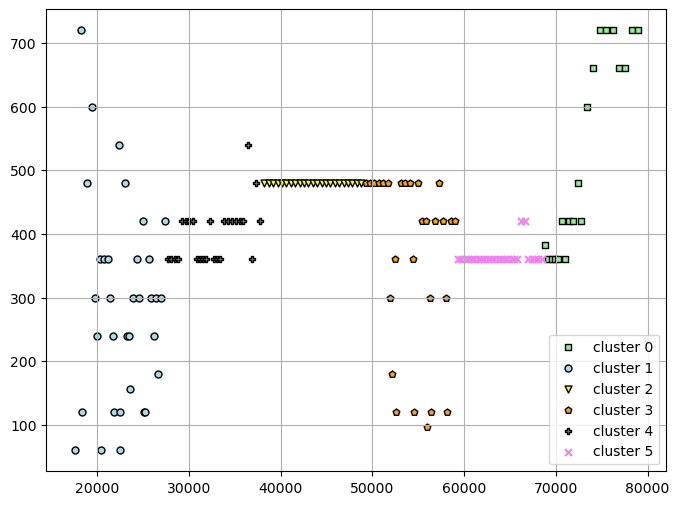

In [36]:
plt.figure(figsize=(8,6))
colors=['lightgreen','lightblue','yellow','orange','grey','violet']

markers=['s','o','v','p','P','x']

for n in range(nCluster):
    plt.scatter(
    Data[km == n]['ArrivalTime'], Data[km == n]['TimeWaited'],
    s=25, c= colors[n],
    marker= markers[n], edgecolor='black',
    label='cluster '+str(n)
    )


# visualise centroids

plt.legend(scatterpoints=1)
plt.grid()
plt.show()

On peut essayer avec un autre code qui permet de choisir la distance de k-means

In [40]:
# define dictionary for distance measures
distance_measures = {'euclidean': 0, 'squared euclidean': 1, 'manhattan': 2, 'chebyshev': 3, 
                    'canberra': 5, 'chi-square': 6}

# function defined to compute purity score using pyclustering for various distance measures
def Clustering(dist_measure,nclust,data):
    initial_centers = random_center_initializer(data.values, nclust, random_state=5).initialize()
    # instance created for respective distance metric
    instanceKm = kmeans(data.values, initial_centers=initial_centers, metric=distance_metric(dist_measure))
    # perform cluster analysis
    instanceKm.process()
    # cluster analysis results - clusters and centers
    pyClusters = instanceKm.get_clusters()
    pyCenters = instanceKm.get_centers()
    # enumerate encoding type to index labeling to get labels
    pyEncoding = instanceKm.get_cluster_encoding()
    pyEncoder = cluster_encoder(pyEncoding, pyClusters, data.values)
    pyLabels = pyEncoder.set_encoding(0).get_clusters()
    # function purity score is defined in previous section

    return(pyClusters,pyCenters)
    #return purity_score(IntervalTimeBetweenVehicle['TimeInterval'].values, pyLabels)

# print results
#for measure, value in distance_measures.items():
    #print(f"The purity score for {measure} distance is {round(pyPurity(value)*100, 2)}%")


In [41]:
Clusters = Clustering(distance_measures['manhattan'],7,Data)[0]
Centers = Clustering(distance_measures['manhattan'],7,Data)[1]

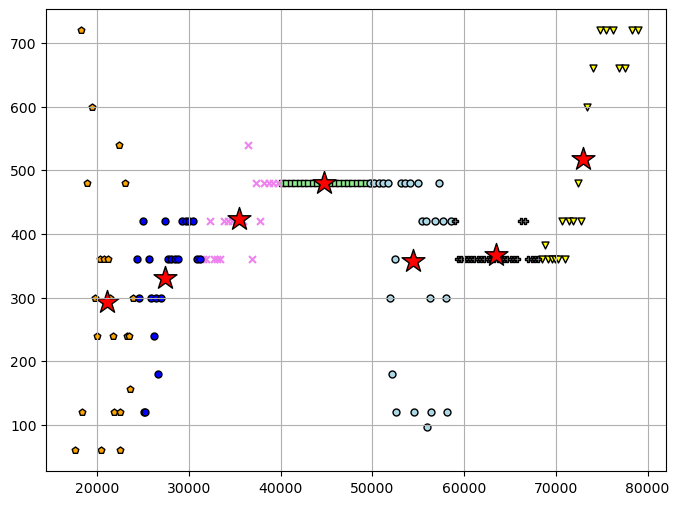

In [42]:
plt.figure(figsize=(8,6))

colors=['lightgreen','lightblue','yellow','orange','grey','violet','blue','red','magenta']

markers=['s','o','v','p','P','x','o','s']

for i,cluster in enumerate(Clusters):
    plt.scatter(
        Data.iloc[cluster,:1], Data.iloc[cluster,1:],
        s=25, c=colors[i],
        marker=markers[i], edgecolor='black',
        label='cluster '+str(i)
    )


# visualise centroids
for center in Centers:
    plt.scatter(
        center[0],center[1],
        s=300, marker='*',
        c='red', edgecolor='black',
        label='centroids'
    )
#plt.legend(scatterpoints=1)
plt.grid()
plt.show()

On peut aussi essayer de Cluster sur les arrival t_i et t_iplus1 de la fonction DataForCluster

In [47]:
DataDelta = DataForClusterDelta('7','0','weekday')

In [48]:
Clusters = Clustering(distance_measures['manhattan'],7,DataDelta)[0]
Centers = Clustering(distance_measures['manhattan'],7,DataDelta)[1]

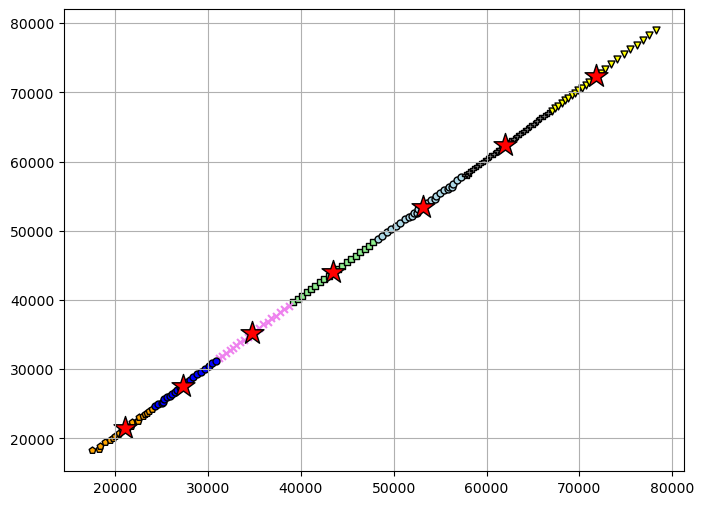

In [50]:
plt.figure(figsize=(8,6))

colors=['lightgreen','lightblue','yellow','orange','grey','violet','blue','red','magenta']

markers=['s','o','v','p','P','x','o','s']

for i,cluster in enumerate(Clusters):
    plt.scatter(
        DataDelta.iloc[cluster,:1], DataDelta.iloc[cluster,1:],
        s=25, c=colors[i],
        marker=markers[i], edgecolor='black',
        label='cluster '+str(i)
    )


# visualise centroids
for center in Centers:
    plt.scatter(
        center[0],center[1],
        s=300, marker='*',
        c='red', edgecolor='black',
        label='centroids'
    )
#plt.legend(scatterpoints=1)
plt.grid()
plt.show()

On peut regarder ce que ce cluster donne sur le graphique initial (attention)

In [51]:
len(Data),len(DataDelta)

(157, 156)

In [52]:
DataInit = DataForCluster('7','0','weekday')
DataInit.drop(0,axis=0,inplace=True)

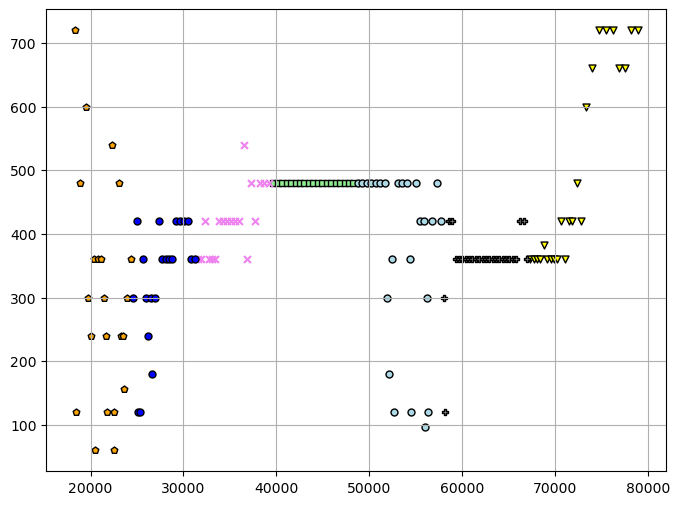

In [53]:
plt.figure(figsize=(8,6))

colors=['lightgreen','lightblue','yellow','orange','grey','violet','blue','red','magenta']

markers=['s','o','v','p','P','x','o','s']

for i,cluster in enumerate(Clusters):
    plt.scatter(
        DataInit.iloc[cluster,:1], DataInit.iloc[cluster,1:],
        s=25, c=colors[i],
        marker=markers[i], edgecolor='black',
        label='cluster '+str(i)
    )


# visualise centroids

#plt.legend(scatterpoints=1)
plt.grid()
plt.show()

Très similaire au Cluster précédent 

On test ici avec le DBSCAN

In [54]:
db = DBSCAN(eps=821, min_samples=4).fit(Data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

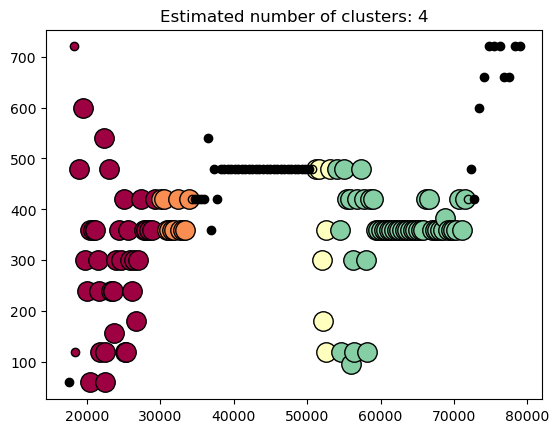

In [55]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colorsDBSCAN = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colorsDBSCAN):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = Data[class_member_mask & core_samples_mask]
    plt.plot(
        xy.iloc[:, 0],
        xy.iloc[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )
    xy = Data[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy.iloc[:, 0],
        xy.iloc[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )
    

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

Vraiment pas concluant,  assez  dur de trouver les bons paramètres
On peut essayer de faire du progressive DBSCAN, et voir quel paramètre nous donne x cluster

In [56]:
EpsRange = np.linspace(100,12000,100)
ClusterDic={}

for Eps in EpsRange:
       for minsample in range(1,100):
              db = DBSCAN(eps=Eps, min_samples=minsample).fit(Data)
              core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
              core_samples_mask[db.core_sample_indices_] = True
              labels = db.labels_
              n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
              n_noise_ = list(labels).count(-1)
              key = str(Eps)+':'+str(minsample)
              ClusterDic[key] = n_clusters_

In [58]:
n_cluster_wanted = 6
value = {i for i in ClusterDic if ClusterDic[i]==n_cluster_wanted}
#format 'EpsRange:Minsample'
value

{'580.8080808080808:4'}

In [59]:
db = DBSCAN(eps=580, min_samples=4).fit(Data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

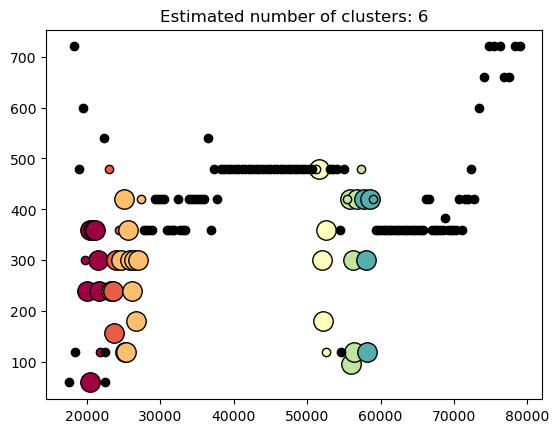

In [60]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colorsDBSCAN = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colorsDBSCAN):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = Data[class_member_mask & core_samples_mask]
    plt.plot(
        xy.iloc[:, 0],
        xy.iloc[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )
    xy = Data[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy.iloc[:, 0],
        xy.iloc[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )
    

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

Bcp de point ne sont pas repris...

Brouillon Pierre

In [ ]:
plt.figure(figsize=(8,6))
colors=['lightgreen','lightblue','yellow','orange','grey','violet']

markers=['s','o','v','p','P','x']

for n in range(nCluster):
    plt.scatter(
    Data[km == n]['Vehicle_i'], Data[km == n]['Vehicle_iPlus1'],
    s=25, c= colors[n],
    marker= markers[n], edgecolor='black',
    label='cluster '+str(n)
    )


# visualise centroids
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    s=300, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()